# Tarea 3: Los K-vecinos 

## Introducción

<img src="vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

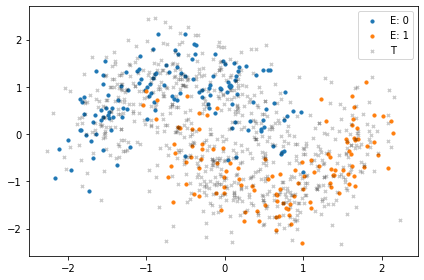

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

### Profiling

In [2]:
%timeit KNN(x,y,z)

1.94 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
#%prun -s cumtime  KNN(x,y,z)

<img src="datos.png">

In [3]:
import line_profiler
%load_ext line_profiler
#%lprun -f KNN KNN(x,y,z)

<img src="datos2.png">

### Resultados y Comentarios

De los resultados del profiling, específicamente de *prun* y *lprun*, podemos ver que el mayor cuello de botella de la función *KNN* está en el primer *for* anidado y en el cálculo de las distancias, con alrededor de 189000 calls o hits, esto se debe a la cantidad de veces que se debe realizar este cálculo, ya que la distancia se calcula por cada punto (MxN veces). Además este cálculo requiere la utilización de múltiples métodos de numpy, lo que podemos observar con *prun*, que si bien es más rápido que utilizar python "puro", hace que el tiempo de ejecución no sea el más óptimo. 

También podemos observar con *lprun* un segundo cuello de botella en el cálculo del *criterion*, pero que causa mucho menos impacto que el primero y esto se debe, al igual que en la primera ocasión, al número de veces que se debe realizar (MxC veces).

### KNN en Cython

In [4]:
%load_ext cython

In [5]:
%%cython
import cython
from libc.stdio cimport printf
import array

cimport numpy as npc
import numpy as np

# Tipo fusionado
ctypedef fused TIPO_t:
    npc.float32_t
    npc.float64_t # double

cdef extern from "math.h":
    npc.float32_t sqrtf(npc.float32_t) #Definición para float32
    npc.float64_t sqrt(npc.float64_t) # Definición para float64
    
def KNN_new(TIPO_t [:, ::1] X, Y, Z, int k=5, double p=2.):
    
    C = np.unique(Y)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    M, _ = Z.shape
    
    #####################
    dist = np.empty(shape=(M, N), dtype=np.double)
    
    cdef double [:, ::1] dist_c = dist
    cdef double suma = 0.0
    cdef int i,j,n,a
    
    for i in range(M):
        for j in range(N):
            for n in range(D):
                suma += (abs(Z[i][n] - X[j][n]))**p
            dist_c[i, j] = suma**(1./p)
            suma = 0.0
    

    neighbours = np.argsort(dist_c, axis=1)[:, :k]
    Z_Y = np.zeros(shape=(M, ))
    for i in range(M):
        #lista de zeros de largo C ([0,1])
        criterion_c = np.zeros(shape=(len(C),))
        for c in C:
            for a in range(k):
                criterion_c[c] += (1./dist[i][neighbours[i][a]] if Y[neighbours[i][a]] == c else 0)
        if (criterion_c[0]>=criterion_c[1]):
            Z_Y[i] = 0.0
        else:
            Z_Y[i] = 1.0
    return Z_Y

### Comparación

In [6]:
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

Text(0.5, 1.0, 'KNN_new')

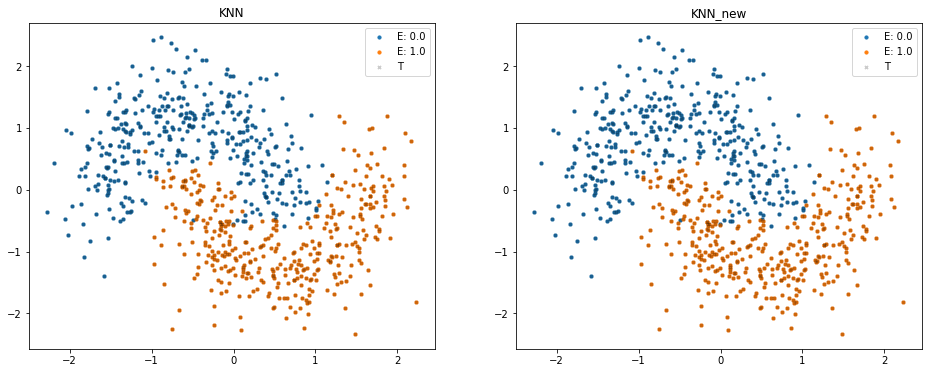

In [7]:
y0 = KNN(x,y,z)
y_new = KNN_new(x,y,z)
x0 = z

fig, ax = plt.subplots(1,2 , figsize=(16, 6))
for c in np.unique(y0):
    mask = y0 == c
    ax[0].scatter(x0[mask, 0], x0[mask, 1], label=f"E: {c}", s=10)
ax[0].scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax[0].legend();
ax[0].set_title('KNN')

for c in np.unique(y_new):
    mask = y_new == c
    ax[1].scatter(x0[mask, 0], x0[mask, 1], label=f"E: {c}", s=10)
ax[1].scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax[1].legend();
ax[1].set_title('KNN_new')

In [8]:
print(True if y0.all()==y_new.all() else False)

True


Como podemos apreciar, los resultados de la función optimizada *KNN_new*, son los mismos que los de la versión original.

### Speed-up

In [11]:
%timeit -r3 -n1 KNN(x,y,z) 

4.26 s ± 481 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [12]:
%timeit -r3 -n1 KNN_new(x,y,z)

311 ms ± 8.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Pese a que los resultados de KNN y KNN_new(optimizada) convergen al mismo resultado, la versión optimizada tarda menos de la décima parte que la función sin optimizar

In [9]:
import time
N=[10,50,100,500,1000,5000,10000]
S=[]

for n in N:
    print(n)
    E, T = create_data(n)
    x, y = E
    z, w = T
    k = 5 if y.size>5 else 2 ##si se deja 5 por defecto KNN_new da error en Y[neighbours[i][a]] cuando N=10
    #print(x.shape, y.shape, z.shape)
    
    start1 = time.time()
    KNN(x, y, z)
    end1 = time.time()
    
    start2 = time.time()
    KNN_new(x, y, z, k)
    end2 = time.time()
    
    tRef = end1-start1
    tProp = end2-start2
    
    S.append(tRef/tProp)

10
50
100
500
1000
5000
10000


[3.4795725958516655,
 8.085703354164009,
 8.962826594916095,
 9.63496248835142,
 9.442156331533743,
 7.711992807248406,
 8.005347035826466]

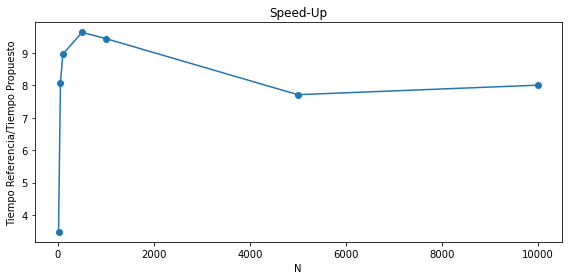

In [10]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.plot(N, S, 'o', linestyle='-')
ax.set(xlabel = 'N', ylabel='Tiempo Referencia/Tiempo Propuesto', title='Speed-Up')
#ax.set_aspect(1000)
S

### Validación Cruzada

In [12]:
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

In [13]:
from sklearn.model_selection import train_test_split
#split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

accs = np.zeros(shape=(10,10))
for k in range(1,11):
    acc = 0
    for p in range(1,11):
        knn = KNN_new(x_train, y_train, x_test, k, p)
        #print(len(knn))
        for i in range(len(knn)):
            acc += (1. if knn[i]==y_test[i] else 0.)
        #print(acc)
        accs[k-1, p-1] = (acc/len(knn))
        #print(acc/len(knn))
        acc = 0
print(accs)
ind = np.unravel_index(np.argmax(accs, axis=None), accs.shape)
print(accs[ind])
print('k: {}, p: {}'.format(ind[0]+1, ind[1]+1))

[[0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86]
 [0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86]
 [0.9  0.92 0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92]
 [0.92 0.92 0.92 0.92 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.92 0.92 0.92 0.92 0.92 0.92 0.94 0.94]]
0.94
k: 3, p: 4


### Evaluación Mejor Clasificador

In [80]:
knn = KNN(x, y, z, 3, 4)
acc = 0
for i in range(len(knn)):
    acc += (1. if knn[i]==w[i] else 0.)
acc /= len(knn)
acc

0.94

In [81]:
####PRUEBA#######
accs = np.zeros(shape=(10,10))
for k in range(1,11):
    acc = 0
    for p in range(1,11):
        knn = KNN_new(x, y, z, k, p)
        #print(len(knn))
        for i in range(len(knn)):
            acc += (1. if knn[i]==w[i] else 0.)
        #print(acc)
        accs[k-1, p-1] = (acc/len(knn))
        #print(acc/len(knn))
        acc = 0
print(accs)
ind = np.unravel_index(np.argmax(accs, axis=None), accs.shape)
print(accs[ind])
print('k: {}, p: {}'.format(ind[0]+1, ind[1]+1))

[[0.928      0.932      0.93466667 0.93333333 0.93333333 0.93333333
  0.93466667 0.932      0.932      0.932     ]
 [0.928      0.932      0.93466667 0.93333333 0.93333333 0.93333333
  0.93466667 0.932      0.932      0.932     ]
 [0.94666667 0.94266667 0.94133333 0.94       0.94133333 0.94133333
  0.94133333 0.94133333 0.94133333 0.94133333]
 [0.94       0.944      0.944      0.944      0.94266667 0.94266667
  0.94266667 0.94266667 0.94266667 0.94266667]
 [0.944      0.94266667 0.94       0.94       0.94       0.94
  0.94       0.94       0.94       0.94      ]
 [0.94933333 0.94933333 0.94533333 0.944      0.94533333 0.94533333
  0.94533333 0.94533333 0.94533333 0.94533333]
 [0.94133333 0.94266667 0.94       0.94266667 0.94266667 0.94266667
  0.94266667 0.94266667 0.94266667 0.94266667]
 [0.94533333 0.94533333 0.948      0.95066667 0.94933333 0.94933333
  0.948      0.94666667 0.94533333 0.94533333]
 [0.93733333 0.94933333 0.94933333 0.94666667 0.944      0.944
  0.94266667 0.94266667

In [35]:
from sklearn.metrics import confusion_matrix

#yhat = clf.predict(x[:, :2])
cm = confusion_matrix(w,  # Etiqueta real
                      y_new # Etiqueta predicha
                     )
print(cm)

[[349  16]
 [ 27 358]]


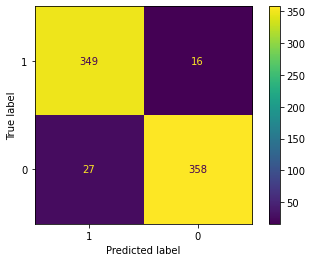

In [48]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(cm, 
                         display_labels=np.array(['1', '0']))
disp.plot()

In [52]:
from sklearn.metrics import accuracy_score
print("Métrica asociada a la precisión: ",accuracy_score(w, y_new))

Métrica de precisión:  0.9426666666666667


Para tener una idea general, la precisión del modelo (cuando no se equivoca) es del ~94%

0.0438, 0.9299, 1.0000


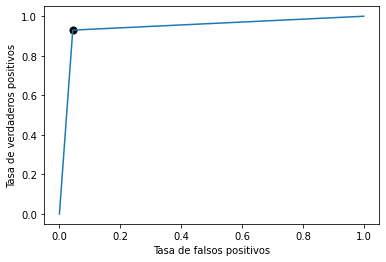

In [53]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(w, y_new)
idx = np.where(tpr > 0.9)[0][0]
print(f"{fpr[idx]:0.4f}, {tpr[idx]:0.4f}, {thresholds[idx]:0.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr, tpr)
ax.scatter(fpr[idx], tpr[idx], s=50, c='k')
ax.set_xlabel('Tasa de falsos positivos')
ax.set_ylabel('Tasa de verdaderos positivos');

Si usamos el umbral R=1 tendremos una tasa de verdaderos positivos de ~93% y una tasa de falsos positivos de ~4%.